In [1]:
import torch
from torchvision import datasets,transforms
from torch import nn,optim,no_grad
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import os
import pickle
%matplotlib inline
np.set_printoptions(suppress=True)

In [2]:
train_dataset=datasets.FashionMNIST('FMNIST/',
                              train=True,
                              download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))
print(train_dataset)

test_dataset=datasets.FashionMNIST('FMNIST/',
                              train=False,
                              download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print(test_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: FMNIST/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None
Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: FMNIST/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None


In [3]:
idx2lbl={0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle boot'}

<table>
<thead>
<tr>
<th>Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>T-shirt/top</td>
</tr>
<tr>
<td>1</td>
<td>Trouser</td>
</tr>
<tr>
<td>2</td>
<td>Pullover</td>
</tr>
<tr>
<td>3</td>
<td>Dress</td>
</tr>
<tr>
<td>4</td>
<td>Coat</td>
</tr>
<tr>
<td>5</td>
<td>Sandal</td>
</tr>
<tr>
<td>6</td>
<td>Shirt</td>
</tr>
<tr>
<td>7</td>
<td>Sneaker</td>
</tr>
<tr>
<td>8</td>
<td>Bag</td>
</tr>
<tr>
<td>9</td>
<td>Ankle boot</td>
</tr>
</tbody>
</table>

In [4]:
train_dataLoader=DataLoader(train_dataset,batch_size=64,shuffle=True)

In [5]:
val_dataloader=DataLoader(test_dataset,batch_size=5000)

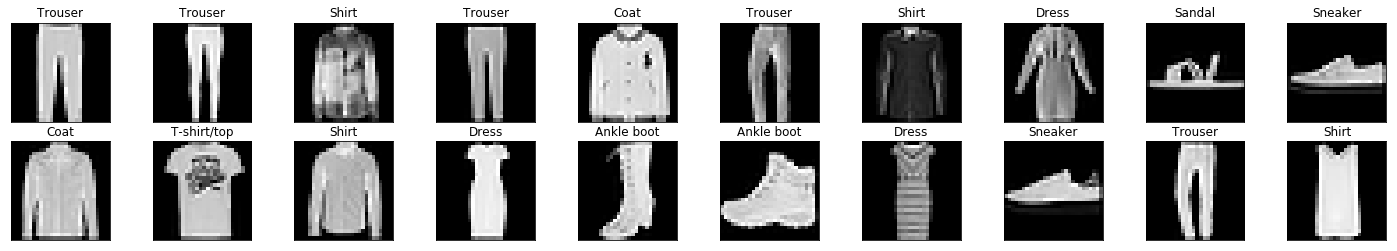

In [6]:
images,labels=next(iter(train_dataLoader))
fig=plt.figure(figsize=(25,4))
for i in range(1,21):
    ax=fig.add_subplot(2,10,i,xticks=[],yticks=[])
    ax.imshow(images[i].view(28,28),cmap='gray')
    ax.set_title(str(idx2lbl[labels[i].item()]))

In [7]:
val_test_data=list(iter(val_dataloader))
val_images,val_labels=val_test_data[0]
test_images,test_labels=val_test_data[1]

In [8]:
test_images=test_images.reshape(-1,784)
val_images=val_images.reshape(-1,784)

In [9]:
model=nn.Sequential(
    nn.Linear(784,128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64,10),
    nn.LogSoftmax(dim=1)
)
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2)
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax()
)

In [10]:
criterion=nn.NLLLoss()

In [11]:
optimizer=optim.Adam(model.parameters(),lr=0.01)

In [12]:
#load data and model to gpu

model.to('cuda')
val_images,val_labels=val_images.cuda(),val_labels.cuda()

In [13]:
epochs=30

train_loss_pe=list()
val_loss_pe=list()

train_acc_pe=list()
val_acc_pe=list()

for epoch in range(1,epochs+1):
    print("EPOCH:",epoch,end=" ")
    running_loss=0
    running_acc=0
    
    for images,labels in train_dataLoader:
        images,labels=images.cuda(),labels.cuda()   
        X=images.view(-1,784)
        
        optimizer.zero_grad()
        output=model.forward(X)
        loss=criterion(output,labels)
        
        result=torch.argmax(output,dim=1)
        running_loss+=loss.item()
        running_acc+=torch.mean((result==labels).type(torch.float))
        
        loss.backward()
        optimizer.step()
    else:
        train_loss=running_loss/len(train_dataLoader)
        train_acc=running_acc/len(train_dataLoader)
        
        with no_grad():
            model.eval()
            output=model.forward(val_images)
            val_loss=criterion(output,val_labels)
            model.train()
        
        result_labels=torch.argmax(output,dim=1)
        accuracy=torch.mean((result_labels==val_labels).type(torch.float))
        
        train_loss_pe.append(train_loss)
        val_loss_pe.append(val_loss.item())
        
        train_acc_pe.append(train_acc.item())
        val_acc_pe.append(accuracy.item())
        
        print("Training Loss: {:.3f}".format(train_loss),end=" ") 
        print("Val Loss: {:.3f}".format(val_loss),end=" ")
        print("Train Accuracy: {:.2f}%".format(train_acc.item()*100),end=" ")
        print("Val Accuracy: {:.2f}%".format(accuracy.item()*100),end=" \n")
        
        with open("Models/mlp_fmnist_model_{}.pth".format(epoch),"wb") as f:
            model.eval()
            pickle.dump(model,f)
            model.train()

EPOCH: 1 Training Loss: 0.717 Val Loss: 0.589 Train Accuracy: 74.88% Val Accuracy: 78.70% 
EPOCH: 2 Training Loss: 0.641 Val Loss: 0.520 Train Accuracy: 78.02% Val Accuracy: 81.34% 
EPOCH: 3 Training Loss: 0.615 Val Loss: 0.520 Train Accuracy: 79.03% Val Accuracy: 82.24% 
EPOCH: 4 Training Loss: 0.614 Val Loss: 0.572 Train Accuracy: 79.44% Val Accuracy: 80.28% 
EPOCH: 5 Training Loss: 0.603 Val Loss: 0.516 Train Accuracy: 79.68% Val Accuracy: 82.34% 
EPOCH: 6 Training Loss: 0.599 Val Loss: 0.539 Train Accuracy: 79.80% Val Accuracy: 81.98% 
EPOCH: 7 Training Loss: 0.587 Val Loss: 0.504 Train Accuracy: 79.98% Val Accuracy: 82.38% 
EPOCH: 8 Training Loss: 0.578 Val Loss: 0.511 Train Accuracy: 80.28% Val Accuracy: 82.06% 
EPOCH: 9 Training Loss: 0.594 Val Loss: 0.513 Train Accuracy: 79.84% Val Accuracy: 82.42% 
EPOCH: 10 Training Loss: 0.573 Val Loss: 0.494 Train Accuracy: 80.38% Val Accuracy: 83.50% 
EPOCH: 11 Training Loss: 0.587 Val Loss: 0.489 Train Accuracy: 80.23% Val Accuracy: 83.06

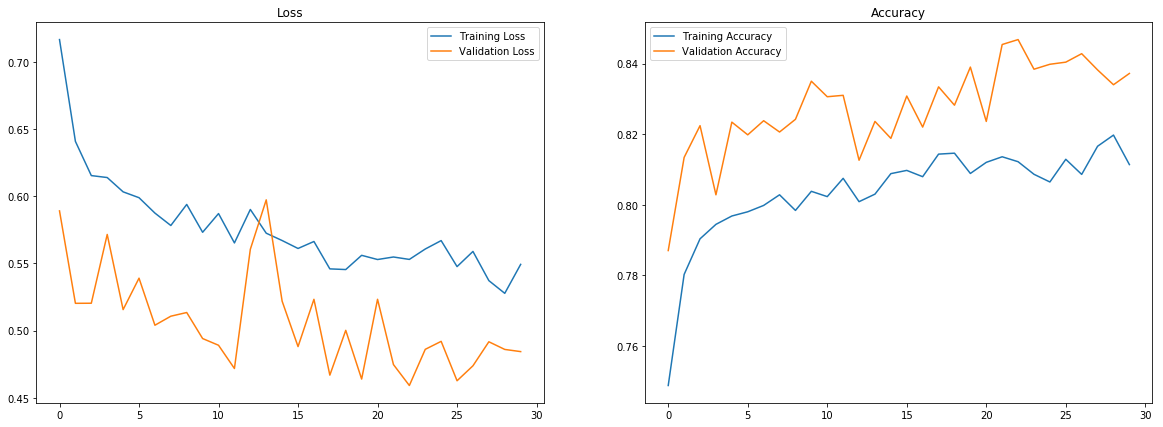

In [14]:
plots=[(train_loss_pe,val_loss_pe),(train_acc_pe,val_acc_pe)]
plt_labels=[("Training Loss","Validation Loss"),("Training Accuracy","Validation Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

In [15]:
#selecting the best model
with open("Models/mlp_fmnist_model_23.pth","rb") as f:
    loaded_model=pickle.load(f)

In [16]:
def predict(model,images):
    model.cpu()
    with no_grad():
        model.eval()
        output=loaded_model.forward(test_images)
        test_loss=criterion(output,test_labels)
        result=torch.argmax(output,dim=1)
        result_labels=[idx2lbl[x] for x in result.numpy()]
    return (test_loss,result,result_labels)

In [17]:
test_loss,result,result_labels=predict(loaded_model,test_images)

In [18]:
accuracy=torch.mean((result==test_labels).type(torch.float))

In [19]:
print("Test Loss: {:.2f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(accuracy*100))

Test Loss: 0.48
Test Accuracy: 84.36%


In [20]:
report=pd.DataFrame.from_dict(classification_report(result,test_labels,output_dict=True)).T

In [21]:
report['Label']=[idx2lbl.get(int(x)) if x.isdigit() else " " for x in report.index]

In [22]:
report=report[['Label','f1-score','precision','recall','support']]

In [23]:
report

,Label,f1-score,precision,recall,support
0,T-shirt/top,0.800395,0.821501,0.780347,519.0
1,Trouser,0.966732,0.951830,0.982107,503.0
2,Pullover,0.743383,0.674322,0.828205,390.0
3,Dress,0.830612,0.814000,0.847917,480.0
4,Coat,0.751342,0.876827,0.657277,639.0
5,Sandal,0.931206,0.906796,0.956967,488.0
6,Shirt,0.576375,0.546332,0.609914,464.0
7,Sneaker,0.921105,0.934000,0.908560,514.0
8,Bag,0.959402,0.947257,0.971861,462.0
9,Ankle boot,0.945489,0.961759,0.929760,541.0
